In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
from datetime import datetime

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

from scipy.stats import beta

In [2]:
#id directories
data_dir = os.getcwd().replace('/model/not_modules', '/input_data/seattle')
results_dir = os.getcwd().replace('/model/not_modules', '/results')

In [3]:
#read data
os.chdir(data_dir)
items_df = pd.read_csv('items_df.csv')
items_df = items_df.dropna() #only include items without nan
incoming_orders_df = pd.read_csv('incoming_orders_df.csv')
incoming_orders_df['Date'] = pd.to_datetime(incoming_orders_df['Date'])

#get time since oldest order
oldest_order = min(incoming_orders_df['Date'])
today = datetime.now()
days_since_oldest_order = (today-oldest_order).days
weeks_since_oldest_order = math.floor(days_since_oldest_order/7)

#to estimate demand
demand_df = items_df[['ItemTypeID', 'DemandPerDay']].groupby('ItemTypeID').sum().reset_index()
demand_df['DemandPerWeek'] = round(demand_df['DemandPerDay']*7,0)

In [4]:
CAP_reliability = -1 # -1 if 1 sd below mean, -2 if 2 sd below mean
DEMAND_reliability = 1 #1 if 1 sd above mean, 2 if 2 sd above mean

budget = 5000000
#warehouse_cap_level = 2 #time intervals of supply that can be stored

In [5]:
#define sets
K = items_df['ItemTypeID'].unique()
I = items_df['ItemID'].unique()
T = 10

In [6]:
#define parameters

r_k_dict = {
}

rank_df = items_df[['ItemTypeID', 'ItemType', 'Essentiality']].\
groupby(['ItemTypeID', 'ItemType'])['Essentiality'].max().reset_index()

for k in rank_df['ItemTypeID']:
    temp = rank_df[rank_df['ItemTypeID']==k]
    
    r_k_dict[k] = temp['Essentiality'].values[0]

#quality 
q_k_i_dict = {
}

for i in items_df['ItemID']:
    temp = items_df[items_df['ItemID'] == i]
    k_temp = temp['ItemTypeID'].values[0]
    quality_temp = temp['Quality'].values[0]
    
    q_k_i_dict[tuple([k_temp,i])] = quality_temp

#starting inventory
z_k_i_init_dict = {
}

for i in items_df['ItemID']:
    temp = items_df[items_df['ItemID'] == i]
    k_temp = temp['ItemTypeID'].values[0]
    beg_inv_temp = temp['BeginningInventory'].values[0]
    
    z_k_i_init_dict[tuple([k_temp,i])] = beg_inv_temp

alpha_k_init_dict = {
}

#for now assuming no open demand
for k in rank_df['ItemTypeID']:
    alpha_k_init_dict[k] = 0

#lead time
f_k_i_tDiff_dict = {}

for i in items_df['ItemID']:
    last_prob = 0
    temp = items_df[items_df['ItemID'] == i]
    max_delay = temp['max_delay'].values[0]
    min_delay = temp['min_delay'].values[0]
    alpha_temp = temp['alpha_delay'].values[0]
    beta_temp = temp['beta_delay'].values[0]
    k_temp = temp['ItemTypeID'].values[0]
    for t in range(T+weeks_since_oldest_order+1): #to make sure the prob distibution can calculate okit
        norm_temp = 0
        if (max_delay - min_delay) != 0:
            norm_temp = (t - min_delay)/(max_delay - min_delay)
        cum_prob_temp = beta.cdf(norm_temp, alpha_temp, beta_temp)
        prob_temp = cum_prob_temp - last_prob
        if np.isnan(prob_temp):
            f_k_i_tDiff_dict[tuple([k_temp, i, t])] = 0
        else:
            f_k_i_tDiff_dict[tuple([k_temp, i, t])] = prob_temp
            
        last_prob = cum_prob_temp

o_k_i_t_dict = {}

for k in K:
    for t in I:
        for t in range(1,T+1):
            o_k_i_t_dict[tuple([k,i,t])] = 0
            
for index in incoming_orders_df.index:
    item_id = incoming_orders_df.ItemTypeID.iloc[index]
    ordered_date = pd.to_datetime(incoming_orders_df['Date']).iloc[index]
    days_since_order = (datetime.now() - pd.to_datetime(incoming_orders_df['Date'])\
                        .iloc[index]).days
    weeks_since_order = math.floor(days_since_order/7)
    amount_ordered = incoming_orders_df.PrimaryQty.iloc[index]
    
    for t in range(1,T+1):
        tDiff = t + weeks_since_order
        o_k_i_t_dict[tuple([k,i,t])] = f_k_i_tDiff_dict[tuple([k,i,tDiff])]*amount_ordered
        
#cost
c_k_i_dict = {
}

for i in items_df['ItemID']:
    temp = items_df[items_df['ItemID'] == i]
    k_temp = temp['ItemTypeID'].values[0]
    cost = temp['cost'].values[0]
    
    c_k_i_dict[tuple([k_temp,i])] = cost
    

b = budget

#capacity
CAP_k_i_t_dict_mu_sd = {}

for i in items_df['ItemID']:
    temp = items_df[items_df['ItemID'] == i]
    k_temp = int(temp['ItemTypeID'].values[0])
    capacity = round(temp['capacity'].values[0],0)
    for t in range(T+1):
        if k_temp == 2:
            CAP_k_i_t_dict_mu_sd[tuple([k_temp,i,t])] = [capacity*10, capacity*.1]
        else:
            CAP_k_i_t_dict_mu_sd[tuple([k_temp,i,t])] = [capacity, capacity*.1]
        
#demand
D_k_t_dict_mu_sd = {
}

for k in demand_df['ItemTypeID']:
    temp = demand_df[demand_df['ItemTypeID'] == k]
    demand_per_week = temp['DemandPerWeek'].values[0]
    
    for t in range(T+1):
        D_k_t_dict_mu_sd[tuple([k,t])] = [demand_per_week, demand_per_week*.1]

In [7]:
CAP_k_i_t_dict_mu_sd.get(tuple([2,4,1]))

[869400.0, 8694.0]

In [8]:
model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = K)
model.I = Set(initialize = I)
model.T = Set(initialize = range(1,T+1))
model.T_beg = model.T|Set(initialize = [0])

####initialize parameters####

def rank_param_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_param_initialize)

#model.r_k.pprint()

def penalty_param_initialize(model, k):
    return(1/model.r_k[k])

model.p_k = Param(model.K, initialize = penalty_param_initialize)

#model.p_k.pprint()

def discount_param_initialize(model, k, t):
    discount_temp = model.p_k[k]
    #time_diff = T-t
    return(1/((1+discount_temp)**(t-1)))

model.tau_k_t = Param(model.K, model.T, initialize = discount_param_initialize)

#model.tau_k_t.pprint()

def quality_param_initialize(model, k, i):
    if q_k_i_dict.get(tuple([k,i])) == None:
        return(0)
    else:
        return(q_k_i_dict.get(tuple([k,i])))

model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

#model.q_k_i.pprint()

def beg_inv_param_initialize(model, k, i):
    if z_k_i_init_dict.get(tuple([k,i])) == None:
        return(0)
    else:
        return(z_k_i_init_dict.get(tuple([k,i])))

model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

#model.z_k_i_init.pprint()

def unfulfilled_demand_param_initialize(model, k):
    return(alpha_k_init_dict.get(k))

model.alpha_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

#model.alpha_k_intialize.pprint()

def delay_dist_param_initialize(model, k, i, t):
    if f_k_i_tDiff_dict.get(tuple([k,i,t])) == None:
        return(0)
    else:
        return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

model.f_k_i_tDiff = Param(model.K, model.I, model.T_beg, initialize = delay_dist_param_initialize)

#model.f_k_i_tDiff.pprint()

def incoming_orders_initialize(model, k, i, t):
    if o_k_i_t_dict.get(tuple([k,i,t])) == None:
        return(0)
    else:
        return(o_k_i_t_dict.get(tuple([k,i,t])))

model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

#model.o_k_i_t.pprint()

def cost_param_initialize(model, k, i):
    if c_k_i_dict.get(tuple([k,i])) == None:
        return(0)
    else:
        return(c_k_i_dict.get(tuple([k,i])))

model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

#model.c_k_i.pprint()

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

#model.b.pprint()

def supplier_cap_param_initialize(model, k, i, t):
    if CAP_k_i_t_dict_mu_sd.get(tuple([k,i,t])) == None:
        return(0)
    else:
        temp = CAP_k_i_t_dict_mu_sd.get(tuple([k,i,t]))
        mean = temp[0]
        sd = CAP_reliability*temp[1]
        return(mean+sd)

model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

#model.cap_k_i_t.pprint()

#assume preparing for one sd above the mean
def mu_plus_sigma_demand_param_initialize(model, k, t):
    temp = D_k_t_dict_mu_sd.get(tuple([k,t]))
    mean = temp[0]
    sd = DEMAND_reliability*temp[1]
    return(mean+sd)

model.d_k_t = Param(model.K, model.T, initialize = mu_plus_sigma_demand_param_initialize)

#model.d_k_t.pprint()

####initialize variables####
model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
model.alpha_k_t = Var(model.K, model.T, within = NonNegativeReals)
model.beta_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)

In [9]:
model.cap_k_i_t.pprint()

cap_k_i_t : Size=910, Index=cap_k_i_t_index, Domain=Any, Default=None, Mutable=False
    Key         : Value
      (1, 1, 1) :      86.4
      (1, 1, 2) :      86.4
      (1, 1, 3) :      86.4
      (1, 1, 4) :      86.4
      (1, 1, 5) :      86.4
      (1, 1, 6) :      86.4
      (1, 1, 7) :      86.4
      (1, 1, 8) :      86.4
      (1, 1, 9) :      86.4
     (1, 1, 10) :      86.4
      (1, 2, 1) : 1814400.0
      (1, 2, 2) : 1814400.0
      (1, 2, 3) : 1814400.0
      (1, 2, 4) : 1814400.0
      (1, 2, 5) : 1814400.0
      (1, 2, 6) : 1814400.0
      (1, 2, 7) : 1814400.0
      (1, 2, 8) : 1814400.0
      (1, 2, 9) : 1814400.0
     (1, 2, 10) : 1814400.0
      (1, 3, 1) :   24688.8
      (1, 3, 2) :   24688.8
      (1, 3, 3) :   24688.8
      (1, 3, 4) :   24688.8
      (1, 3, 5) :   24688.8
      (1, 3, 6) :   24688.8
      (1, 3, 7) :   24688.8
      (1, 3, 8) :   24688.8
      (1, 3, 9) :   24688.8
     (1, 3, 10) :   24688.8
      (1, 4, 1) :         0
      (1, 4, 2) :      

In [10]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t]*model.beta_k_i_t[k,i,t] 
                                                      for t in model.T) 
                                 for i in model.I for k in model.K)),
                            sense = maximize)

#model.Objective.pprint()

In [11]:
def beggining_inventory_constraint_initialize(model, k, i):
    if (model.z_k_i_init[k,i] != None):
        return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])
    else:
        return(Constraint.Skip)
    
model.beggining_inventory_constraint = Constraint(model.K, model.I, 
                                                  rule = beggining_inventory_constraint_initialize)
#model.beggining_inventory_constraint.pprint()

In [12]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.alpha_k_t[k,1] == model.alpha_k_intialize[k])

model.initalize_unsatisfied_demand_constraint_initialize = \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

#model.initalize_unsatisfied_demand_constraint_initialize.pprint()

In [13]:
def incoming_orders_constraint_initialize(model, k, i, t):
    return(model.y_k_i_t[k,i,t] - 
           sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
               for t_ordered_time in range(1,t)) == 0)#- model.o_k_i_t[k,i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

#model.incoming_ordered_constraint.pprint()

In [14]:
def calculate_available_inventory_constraint_initialize(model, k, i, t):
    if (t > 1):
        return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + model.beta_k_i_t[k,i,t-1] == 0)
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

#model.calculate_available_inventory_constraint.pprint()

In [15]:
def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
    return(model.beta_k_i_t[k,i,t] - model.z_k_i_t[k,i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

In [16]:
def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
    if t > 1:
        return(model.alpha_k_t[k,t] - model.alpha_k_t[k,t-1] + sum(model.beta_k_i_t[k,i,t] for i in model.I) == \
               model.d_k_t[k,t])
    else:
        return(Constraint.Skip)

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)

In [17]:
def budget_constraint_initialize(model):
    return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
               for k in model.K for i in model.I for t in model.T) 
           <= model.b)

model.budget_constraint = \
Constraint(rule = budget_constraint_initialize)

In [18]:
def supplier_constraint_initialize(model, k, i, t):
    return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

model.supplier_constraint = \
Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)

In [19]:
opt = SolverFactory('gurobi_persistent')
opt.set_instance(model)
opt.solve(model)

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{'Problem': [{'Name': 'unknown', 'Lower bound': 18362281.62839182, 'Upper bound': 18362281.62839182, 'Number of objectives': 1, 'Number of constraints': 3711, 'Number of variables': 3710, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 3710, 'Number of nonzeros': 8379, 'Sense': -1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.01', 'Status': 'ok', 'Wallclock time': 0.01578688621520996, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [20]:
CAP_k_i_t_dict_mu_sd

{(1, 1, 0): [96.0, 9.600000000000001],
 (1, 1, 1): [96.0, 9.600000000000001],
 (1, 1, 2): [96.0, 9.600000000000001],
 (1, 1, 3): [96.0, 9.600000000000001],
 (1, 1, 4): [96.0, 9.600000000000001],
 (1, 1, 5): [96.0, 9.600000000000001],
 (1, 1, 6): [96.0, 9.600000000000001],
 (1, 1, 7): [96.0, 9.600000000000001],
 (1, 1, 8): [96.0, 9.600000000000001],
 (1, 1, 9): [96.0, 9.600000000000001],
 (1, 1, 10): [96.0, 9.600000000000001],
 (1, 2, 0): [2016000.0, 201600.0],
 (1, 2, 1): [2016000.0, 201600.0],
 (1, 2, 2): [2016000.0, 201600.0],
 (1, 2, 3): [2016000.0, 201600.0],
 (1, 2, 4): [2016000.0, 201600.0],
 (1, 2, 5): [2016000.0, 201600.0],
 (1, 2, 6): [2016000.0, 201600.0],
 (1, 2, 7): [2016000.0, 201600.0],
 (1, 2, 8): [2016000.0, 201600.0],
 (1, 2, 9): [2016000.0, 201600.0],
 (1, 2, 10): [2016000.0, 201600.0],
 (1, 3, 0): [27432.0, 2743.2000000000003],
 (1, 3, 1): [27432.0, 2743.2000000000003],
 (1, 3, 2): [27432.0, 2743.2000000000003],
 (1, 3, 3): [27432.0, 2743.2000000000003],
 (1, 3, 4): 

In [21]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])

In [22]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_k_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'item_type']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[1])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[2])

In [23]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])

In [24]:
#extract expected available df
available_df = pd.DataFrame(list(model.z_k_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'item_type']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[1])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[2])

In [25]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.alpha_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [26]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [27]:
ordered_and_recieved_df = ordered_df[['item_type', 'supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['item_type', 'supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [28]:
#os.chdir(results_dir)
ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

In [29]:
recieved_df[(recieved_df['item_type'] == 2) & (recieved_df['expected_units_recieved'] > 0)]

,sets,expected_units_recieved,item_type,supplier,time_interval
171,"(2, 5, 2)",202950.0,2,5,2
172,"(2, 5, 3)",202950.0,2,5,3
173,"(2, 5, 4)",202950.0,2,5,4
174,"(2, 5, 5)",202950.0,2,5,5
175,"(2, 5, 6)",202950.0,2,5,6
176,"(2, 5, 7)",202950.0,2,5,7
177,"(2, 5, 8)",202950.0,2,5,8
178,"(2, 5, 9)",202950.0,2,5,9


In [30]:
available_df[(available_df['item_type'] == 2) & (available_df['units_available'] > 0)]

,sets,units_available,item_type,supplier,time_interval
160,"(2, 4, 1)",764750.0,2,4,1
170,"(2, 5, 1)",457647.0,2,5,1
172,"(2, 5, 3)",202950.0,2,5,3
173,"(2, 5, 4)",202950.0,2,5,4
174,"(2, 5, 5)",202950.0,2,5,5
175,"(2, 5, 6)",202950.0,2,5,6
176,"(2, 5, 7)",202950.0,2,5,7
177,"(2, 5, 8)",202950.0,2,5,8
178,"(2, 5, 9)",202950.0,2,5,9
179,"(2, 5, 10)",202950.0,2,5,10


In [31]:
demand_df[demand_df['item_type'] == 2]

,sets,demand_in_units,item_type,time_interval
10,"(2, 1)",413567.0,2,1
11,"(2, 2)",413567.0,2,2
12,"(2, 3)",413567.0,2,3
13,"(2, 4)",413567.0,2,4
14,"(2, 5)",413567.0,2,5
15,"(2, 6)",413567.0,2,6
16,"(2, 7)",413567.0,2,7
17,"(2, 8)",413567.0,2,8
18,"(2, 9)",413567.0,2,9
19,"(2, 10)",413567.0,2,10


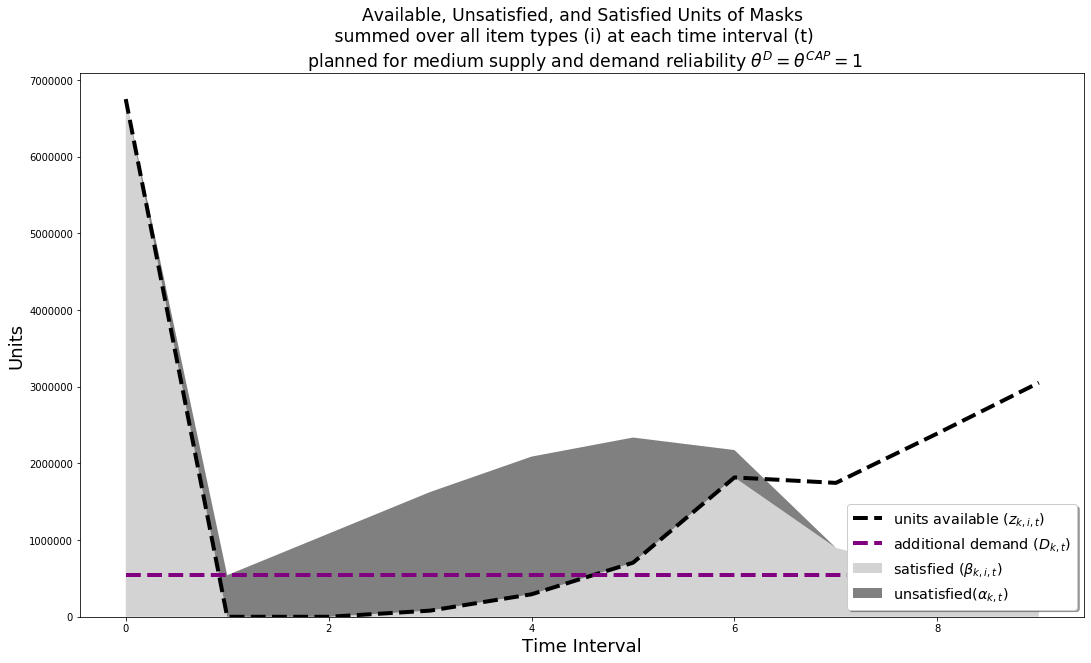

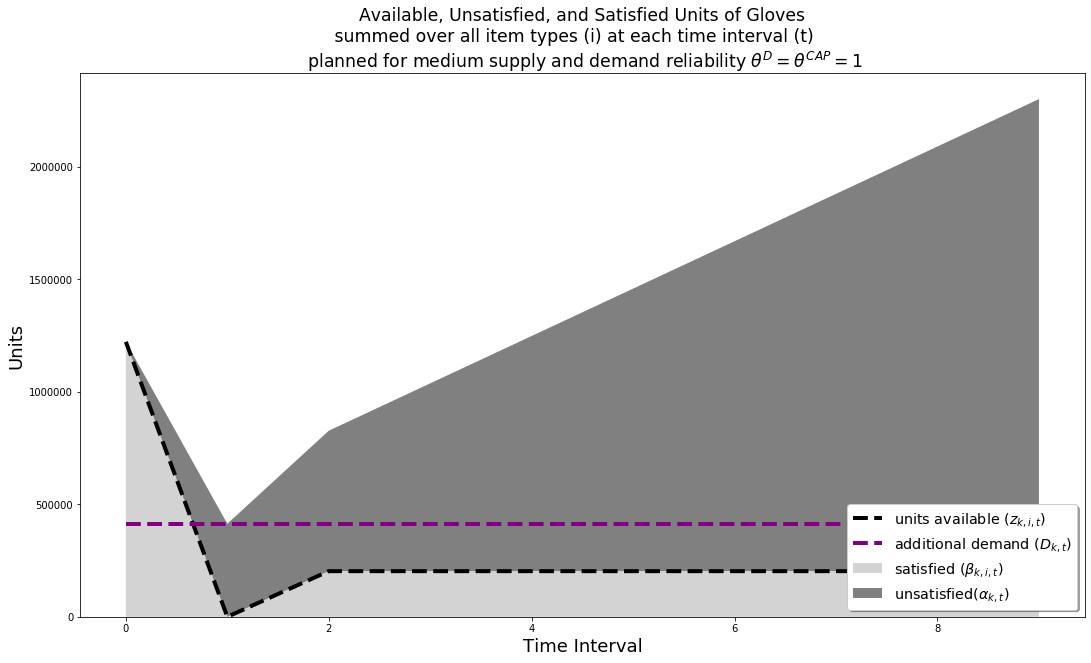

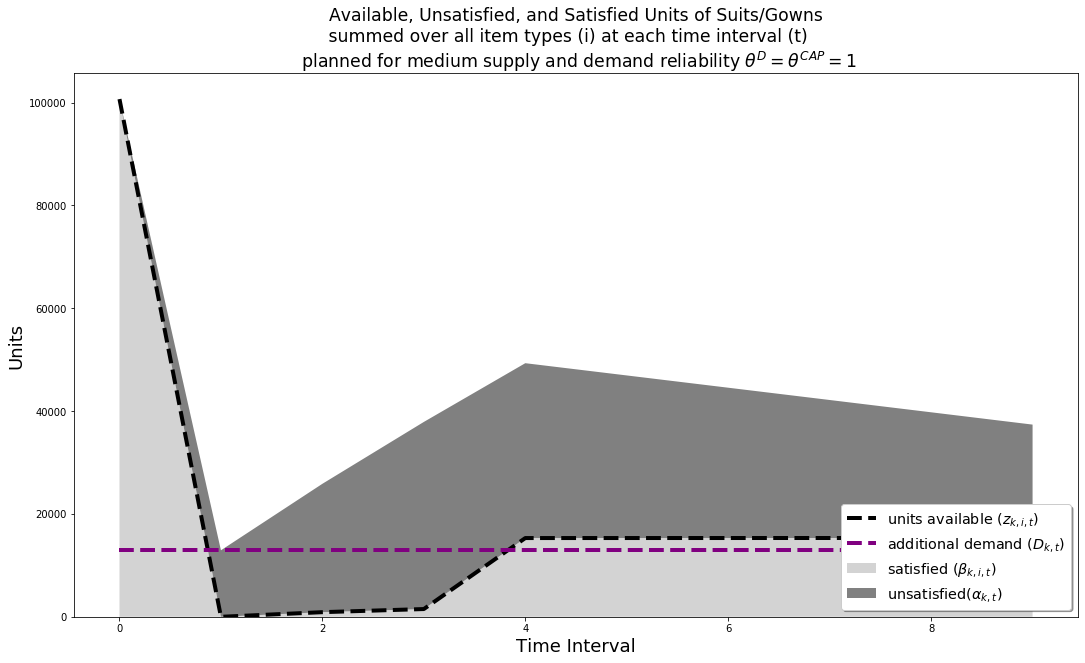

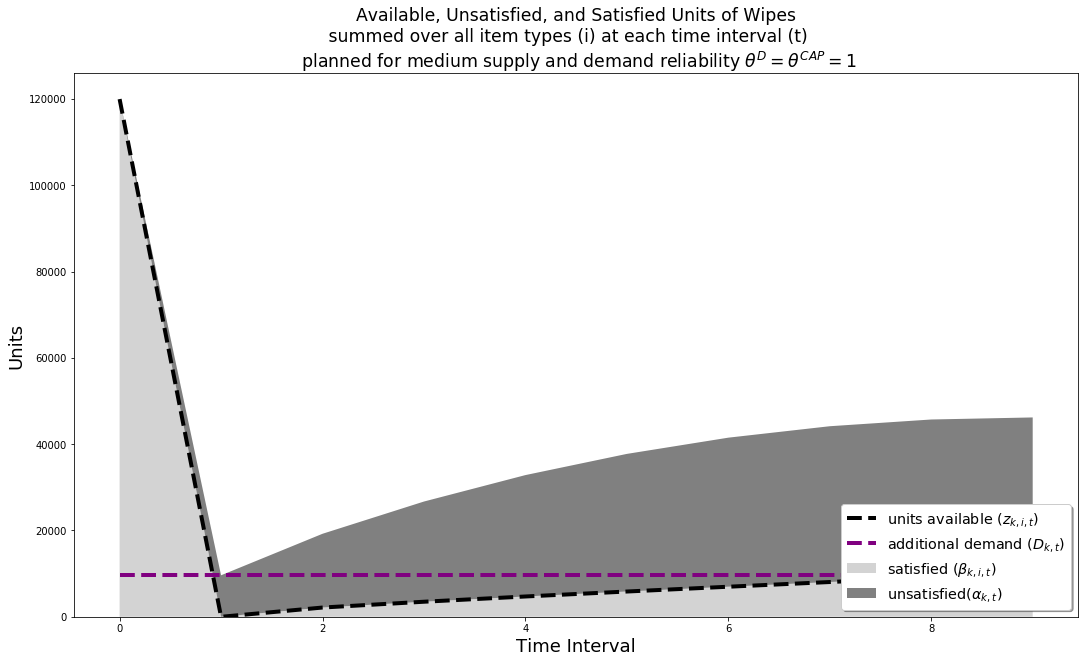

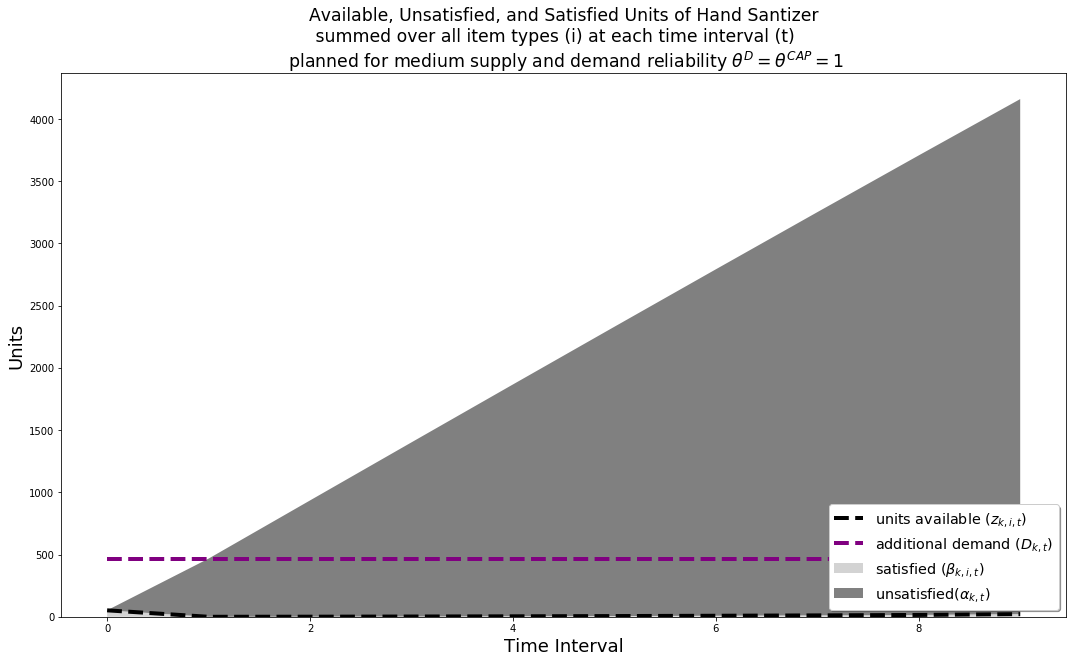

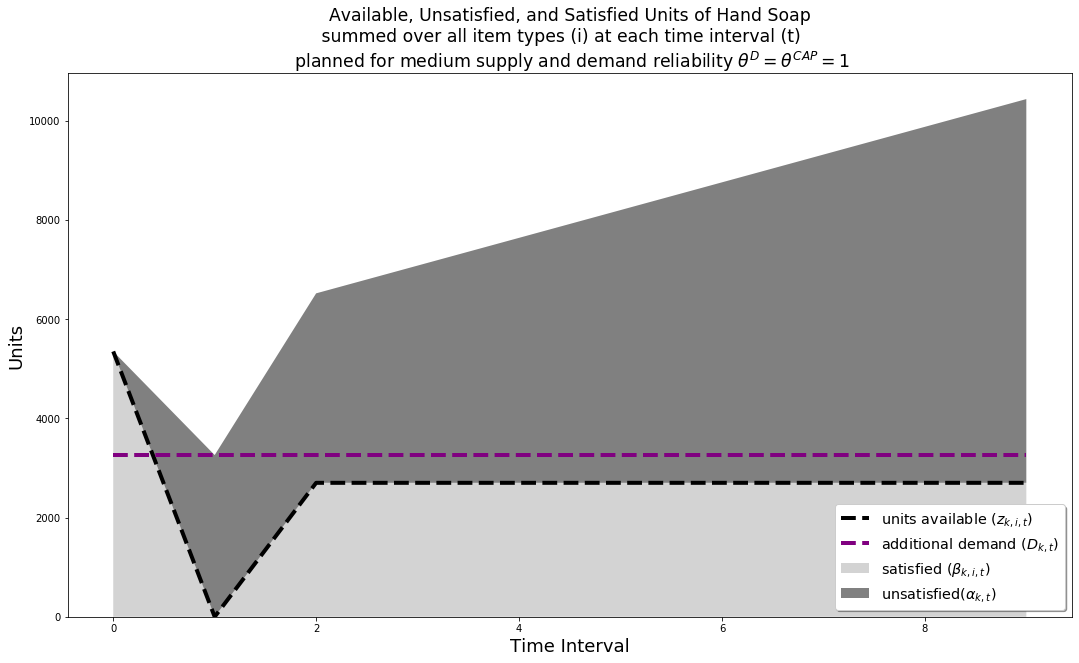

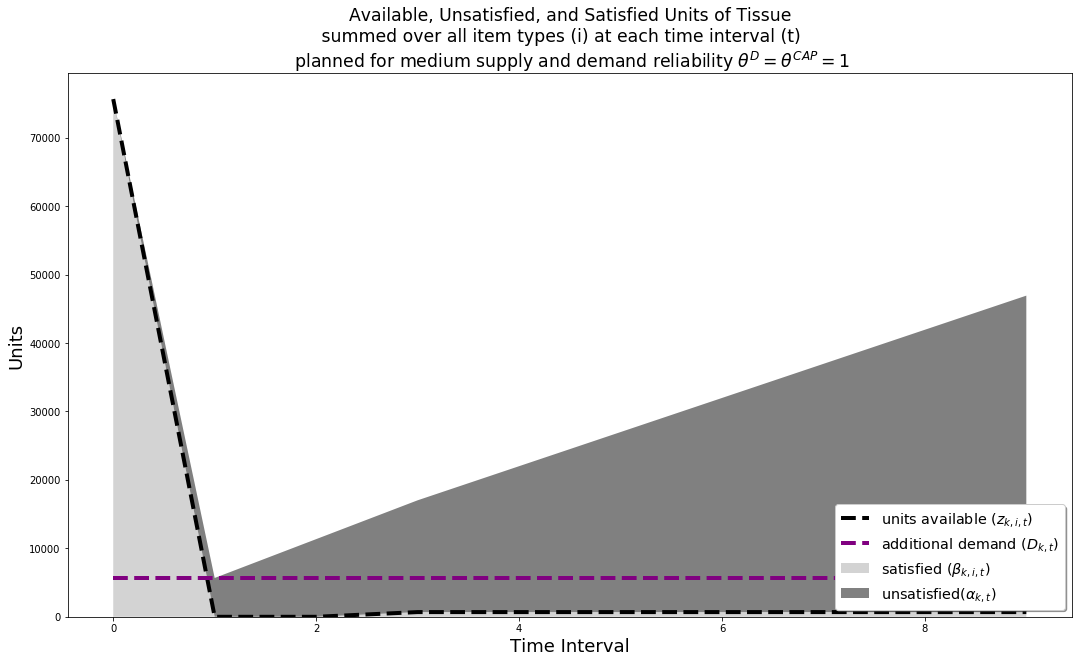

In [32]:
temp_all_2 = pd.DataFrame()

for k in K:
    
    unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == k]
    fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == k].groupby(['time_interval'])["units_fulfilled"]\
    .sum().reset_index()
    available_temp_df = available_df[available_df['item_type'] == k].groupby(['time_interval'])["units_available"]\
    .sum().reset_index()
    demand_temp_df = demand_df[demand_df['item_type'] == k]
    
    
    temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
    merge(fulfilled_temp_df, how='inner', on='time_interval')
    
    #temp_all['item_type'] = [k]*len(temp_all)
    
    #temp_all_2 = temp_all_2.append(temp_all)

    fig2, ax2 = plot.subplots(figsize=(18,10))

    ax2.plot(available_temp_df['time_interval']-1, 
              available_temp_df['units_available'], 
              label='units available ('+r'$z_{k,i,t}$' + ')',
              color ="black",
             linewidth=4,
             linestyle='dashed') 

    ax2.plot(demand_temp_df['time_interval']-1, 
             demand_temp_df['demand_in_units'], 
             label='additional demand ('+r'$D_{k,t}$' + ')',
             linewidth=4,
             color = "purple",
             linestyle='dashed')

    # Your x and y axis
    x=range(0,T)
    y=[temp_all['units_fulfilled'], temp_all['units_unsatisfied']]

    # use a known color palette (see..)
    pal = ["#D3D3D3", "#808080"]
    plot.stackplot(x,y, labels=['satisfied ('+r'$\beta_{k,i,t}$' + ')', 'unsatisfied('+r'$\alpha_{k,t}$' + ')'], colors=pal)
    plot.legend(loc='upper right')

    ax2.set_xlabel('Time Interval', fontsize=18)
    ax2.set_ylabel('Units', fontsize=18)
    item_type_name = items_df[items_df['ItemTypeID'] == k].ItemType.unique()[0]
    ax2.set_title('Available, Unsatisfied, and Satisfied Units of ' + item_type_name + '\n summed over all item types (i) at each time interval (t)\
    \n planned for medium supply and demand reliability '+ r'$\theta^D = \theta^{CAP} = 1$', fontsize='xx-large')
    ax2.legend(loc='lower right', shadow=True, fontsize='x-large')
    
    #ax2.show()

In [33]:
units = []
item = []
time_interval = []
item_type = []

for i in fulfilled_df.index:
    units.append(fulfilled_df['units_fulfilled'].iloc[i])
    time_interval.append(fulfilled_df['time_interval'].iloc[i])
    item_id_temp = fulfilled_df['item_type'].iloc[i]
    item.append(items_df[items_df['ItemTypeID'] == item_id_temp].values[0][3])
    item_type.append(items_df[items_df['ItemTypeID'] == item_id_temp].values[0][1])

for i in unsatisfied_df.index:
    units.append(unsatisfied_df['units_unsatisfied'].iloc[i])
    time_interval.append(unsatisfied_df['time_interval'].iloc[i])
    item.append('unsatisfied_demand')

In [34]:
temp = pd.DataFrame(list(zip(item_type, item, time_interval, units)), 
                    columns =['item_type', 'item', 'time_interval', 'units']) 

In [35]:
temp2 = temp[temp['item_type'] == 'Masks']
temp3 = temp2.pivot(index='time_interval', columns='item', values='units')
pivot_df.plot.bar(stacked=True)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
for item_types in temp['item_type'].unique:
    
    temp2 = temp[temp['item_type'] == item_types]
    
    fig2, ax3 = plot.subplots(figsize=(18,10))

    ax3.plot(available_temp_df['time_interval']-1, 
              available_temp_df['units_available'],  
              label='units available ('+ r'$z_{k,i,t}$' + ') summed over suppliers',
              color ="black",
             linewidth=4,
             linestyle='dashed') 

    ax3.plot(demand_df['time_interval']-1, 
                 demand_df['demand_in_units'], 
                 label='additional demand (' + r'$D_{k,t}$' + ')',
                 color ="purple",
             linewidth=4,
            linestyle='dashed')

    # Your x and y axis
    x=range(0,T)
    
    for num, month in enumerate(months):
        values = list(temp2[temp2['item'] == month].loc[:, 'Value'])
        df[df['Month'] == month].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                          bottom = margin_bottom, color=colors[num], label=month)
        margin_bottom += values
    
    # use a known color palette (see..)
    #pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
    #ax3.stackplot(x,y)#, labels=['Surgical Masks (High Capacity) '+ r'$\beta_{k,i = 1,t}$', 'Cloth Masks (Affordable) ' + r'$\beta_{k,i = 2,t}$', 'Face masks with valves (Speedy) '+ r'$\beta_{k,i = 3,t}$', 
                                #'N95 (High Quality) '+r'$\beta_{k,i = 4,t}$', 'Unsatisfied Demand ' +r'$\alpha_{k,t}$'], colors=pal)#, alpha=0.4)

    ax3.set_xlabel('Time Interval', fontsize=18)
    ax3.set_ylabel('Units', fontsize=18)
    ax3.set_title('Available, Unsatisfied, and Satisfied Units of Masks (k=1) for each Supplier (i) at each Time Interval (t)\
    \n medium supplier risk, medium demand reliability', fontsize='xx-large')
    ax3.legend(loc='lower right', shadow=True, fontsize='x-large')

In [ ]:
pos_dict_all = {}
label_dict_all = {}
color_dict_all = {}
G_dict_all = {}

In [ ]:
for i in I:
    G=nx.Graph()
    label_dict = {}
    color_map = []
    
    global ordered_df
    global recieved_df
    
    time_coordinates = range(1,T+1)
    ordered_amount_coordinates = np.array(ordered_df[(ordered_df['supplier'] == i)]['units_to_order'])
    recieved_amount_coordinates = np.array(recieved_df[(recieved_df['supplier'] == i)]['expected_units_recieved'])

    for t in range(T):
        ordered_amount = ordered_amount_coordinates[t]
        recieved_amount = recieved_amount_coordinates[t]

        if (ordered_amount > 0):
            name = str(t) + 'planned units to order' + str(ordered_amount)
            G.add_node(name, pos = (t+1,1))
            label_dict[name] = round(ordered_amount).astype(int)
            color_map.append('plum')

        if (recieved_amount > 0):
            name = str(t) + 'expected number of units recieved' + str(recieved_amount)
            G.add_node(name, pos = (t+1,2))
            label_dict[name] = round(recieved_amount).astype(int)
            color_map.append('palegreen')

    pos=nx.get_node_attributes(G,'pos')
    label_dict_all['supplier' + str(i)] = label_dict
    color_dict_all['supplier' + str(i)] = color_map
    pos_dict_all['supplier' + str(i)] = pos
    G_dict_all['supplier' + str(i)] = G

In [ ]:
for i in range(1, I+1):

    fig, ax = plot.subplots(figsize=(12,6))
    nx.draw(G_dict_all.get('supplier' + str(i)),
            pos_dict_all.get('supplier' + str(i)), 
            labels=label_dict_all.get('supplier' + str(i)), 
            node_size=2000, font_size=16, with_labels = True, 
            node_color=color_dict_all.get('supplier' + str(i)), 
            ax = ax)
    ax.set_xlabel('Time Interval Ordered and Recieved',
                 fontsize = 18)
    ax.set_ylabel('Place Order             Recieved Order',
                 fontsize = 18)
    ax.set(ylim=(.5, 2.5))
    ax.set_title('Time Interval Order is Placed and Recieved \n for Item Type '+ str(i)+' for Item  k = 1',
                fontsize = 20)
    ax.tick_params(left=True, bottom=True, labelleft=False, labelbottom=True)
    limits=plot.axis('on')
    plot.savefig('Item_1_Supplier' + str(i)+'.jpg')